In [73]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow import keras
from tensorflow.keras import layers
import os
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, BatchNormalization
from keras.models import Sequential
from tensorflow.python.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint

In [74]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.18.0
Num GPUs Available:  0


In [75]:
train_data = keras.utils.image_dataset_from_directory(
    directory = 'images/train',
    labels = 'inferred',
    label_mode = 'int',
    color_mode = 'grayscale',
    batch_size = 32,
    image_size = (48, 48)
)

Found 28679 files belonging to 7 classes.


In [76]:
validation_data = keras.utils.image_dataset_from_directory(
    directory = 'images/test',
    labels = 'inferred',
    label_mode = 'int',
    color_mode = 'grayscale',
    batch_size = 32,
    image_size = (48, 48)
)

Found 7177 files belonging to 7 classes.


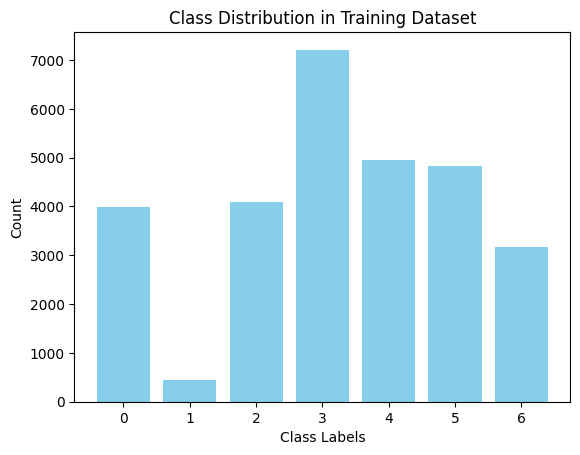

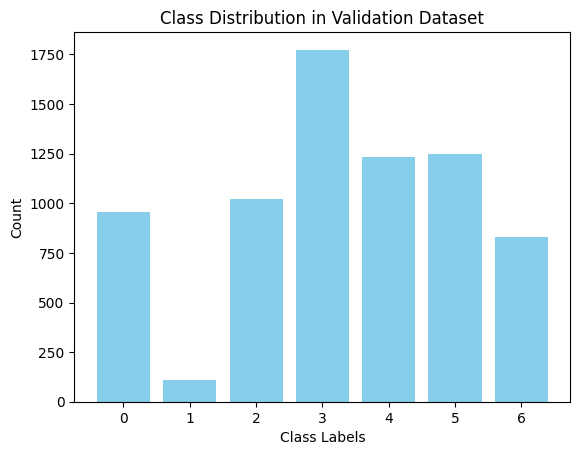

In [77]:
def plot_distribution(dataset, title):
    labels = []
    for _, label in dataset.unbatch():
        labels.append(label.numpy())  # Append the scalar value

    unique, counts = np.unique(labels, return_counts=True)
    plt.bar(unique, counts, color='skyblue')
    plt.xlabel("Class Labels")
    plt.ylabel("Count")
    plt.title(title)
    plt.show()

# Plot initial class distribution
plot_distribution(train_data, "Class Distribution in Training Dataset")
plot_distribution(validation_data, "Class Distribution in Validation Dataset")

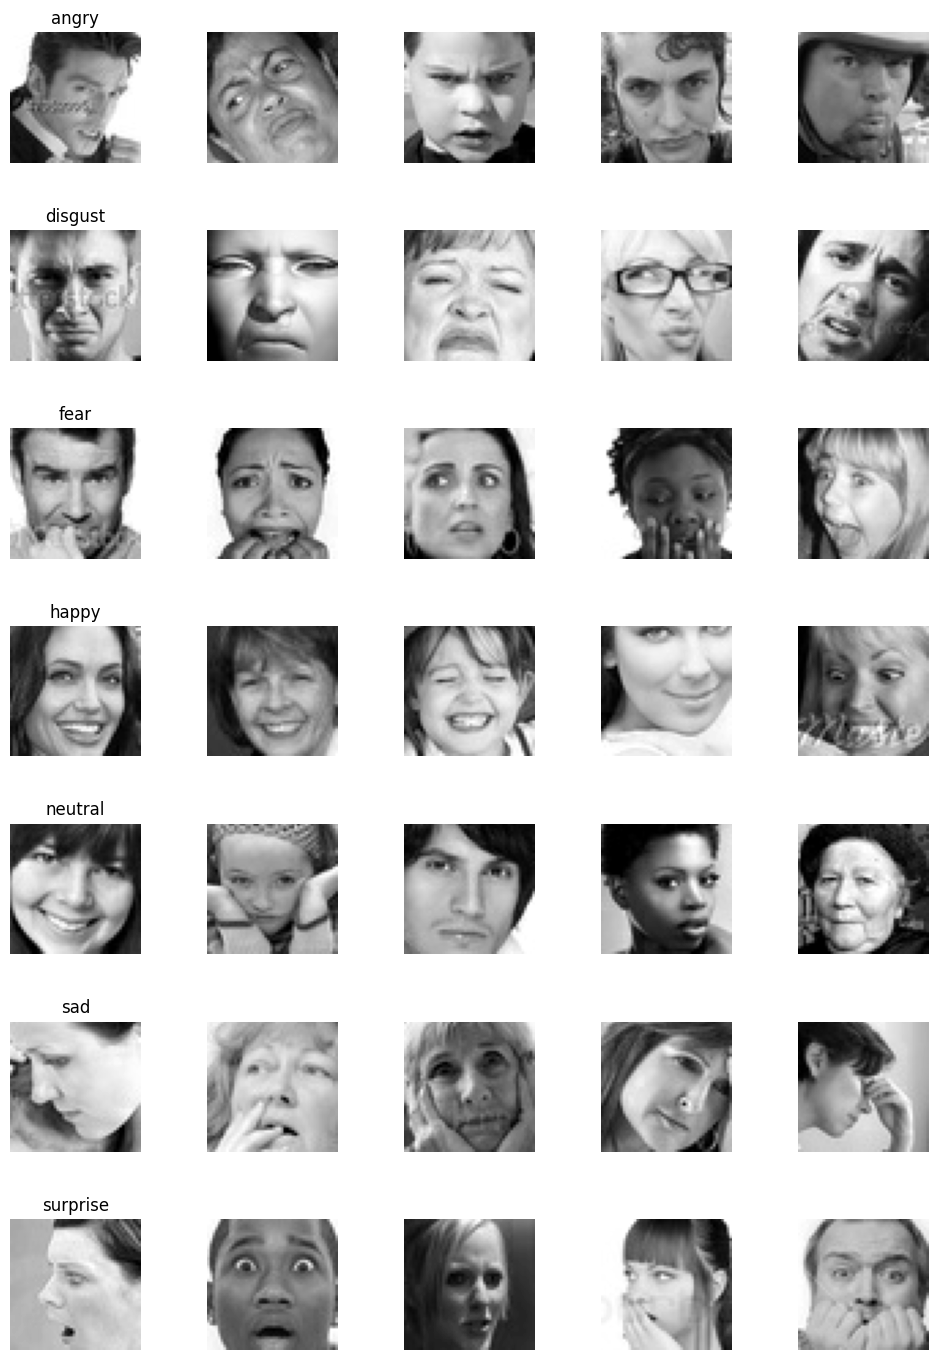

In [78]:
def plot_images_by_class(dataset, class_names, num_images_per_class=5):
    """
    Plot a few sample images for each class from the dataset.

    :param dataset: The dataset to sample from.
    :param class_names: List of class names corresponding to labels.
    :param num_images_per_class: Number of images to display per class.
    """
    # Create a dictionary to store images for each class
    images_by_class = {class_label: [] for class_label in range(len(class_names))}

    for image, label in dataset.unbatch():
        label = label.numpy()
        if len(images_by_class[label]) < num_images_per_class:
            images_by_class[label].append(image.numpy())
        if all(len(images) == num_images_per_class for images in images_by_class.values()):
            break

    # Plot images with a smaller figure size
    fig, axs = plt.subplots(len(class_names), num_images_per_class, figsize=(10, 2 * len(class_names)))  # Reduced figsize
    fig.tight_layout()

    for class_label, images in images_by_class.items():
        for i, img in enumerate(images):
            ax = axs[class_label, i] if len(class_names) > 1 else axs[i]
            ax.imshow(img.astype("uint8"), cmap='gray')
            ax.axis("off")
            if i == 0:
                ax.set_title(class_names[class_label])

    plt.show()

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
plot_images_by_class(train_data, class_names)

In [79]:
def Normalize(image, label):
  image = tf.cast(image/255.0, tf.float32)
  return image,label

#validate = validation_data.map(Normalize)

In [80]:
# Extract data from train dataset
def extract_images_and_labels(dataset):
    X, y = [], []
    for image, label in dataset.unbatch():
        X.append(image.numpy())
        y.append(label.numpy())
    return np.array(X), np.array(y)

# Assuming train_data is loaded correctly
train_images, train_labels = extract_images_and_labels(train_data)

In [81]:
df_train = pd.DataFrame({'image': np.arange(len(train_labels)), 'emotion': train_labels})

In [82]:
train_data = train_data.shuffle(buffer_size=600)
validation_data = validation_data.shuffle(buffer_size=600)

In [83]:
num_classes = 7

In [84]:
import os.path
model_file = "my_model.keras"
'''
if os.path.isfile(model_file):
    print(f"Loaded existing model: {model_file}")
    model = tf.keras.models.load_model(model_file)
'''
model = Sequential()
model.add(tf.keras.layers.Rescaling(1./255, input_shape=(48,48,1)))
model.add(Conv2D(32, (3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3,3), padding="Same", activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (5,5), padding="Same", activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [85]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [86]:
model.compile(optimizer = optimizer, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [87]:
model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling_8 (Rescaling)              │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_37 (Conv2D)                   │ (None, 48, 48, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_18               │ (None, 48, 48, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_38 (Conv2D)                   │ (None, 48, 48, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_18 (MaxPooling2D)      │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 24, 24, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_39 (Conv2D)                   │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_19               │ (None, 24, 24, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_40 (Conv2D)                   │ (None, 24, 24, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_19 (MaxPooling2D)      │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_41 (Conv2D)                   │ (None, 12, 12, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_20               │ (None, 12, 12, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_42 (Conv2D)                   │ (None, 12, 12, 128)         │         409,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_20 (MaxPooling2D)      │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,813,095 (6.92 MB)

 Trainable params: 1,812,647 (6.91 MB)

 Non-trainable params: 448 (1.75 KB)

In [88]:
filepath="weights-improvement-{epoch:02d}-{loss:.4f}.keras"
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [89]:
history = model.fit(train_data, epochs=50, validation_data=validation_data, callbacks=callbacks_list)

Epoch 1/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.2271 - loss: 1.9988
Epoch 1: loss improved from inf to 1.84342, saving model to weights-improvement-01-1.8434.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 94s 81ms/step - accuracy: 0.2271 - loss: 1.9986 - val_accuracy: 0.2596 - val_loss: 1.7958
Epoch 2/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3256 - loss: 1.6980
Epoch 2: loss improved from 1.84342 to 1.66317, saving model to weights-improvement-02-1.6632.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 74s 81ms/step - accuracy: 0.3256 - loss: 1.6980 - val_accuracy: 0.3542 - val_loss: 1.6655
Epoch 3/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3898 - loss: 1.5728
Epoch 3: loss improved from 1.66317 to 1.55530, saving model to weights-improvement-03-1.5553.keras
897/897 ━━━━━━━━━━━━━━━━━━━━ 75s 82ms/step - accuracy: 0.3898 - loss: 1.5727 - val_accuracy: 0.3871 - val_loss: 1.6239
Epoch 4/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4227 - loss: 1.4948

In [90]:
model.save(model_file)

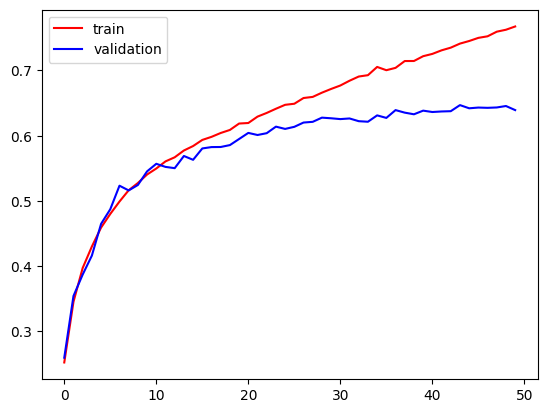

In [91]:
plt.plot(history.history['accuracy'], color = 'red', label = 'train')
plt.plot(history.history['val_accuracy'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

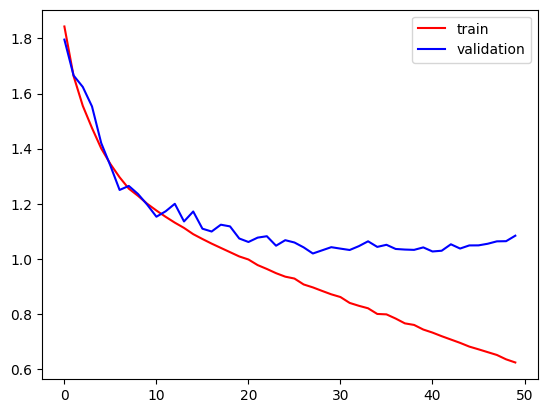

In [92]:
plt.plot(history.history['loss'], color = 'red', label = 'train')
plt.plot(history.history['val_loss'], color = 'blue', label = 'validation')
plt.legend()
plt.show()

In [95]:
# Evaluate model
loss, accuracy = model.evaluate(validation_data)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

225/225 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.6440 - loss: 1.0750
Validation Accuracy: 63.93%
